In [1]:
import numpy as np
from scipy.stats.distributions import norm
import matplotlib.pylab as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot

/usr/lib/python3/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Téma 3: ACF, PACF, autoregresní modely

## Korelační koeficient (lineární, též Pearsonův)

Mějme dvě náhodné veličiny $X$ a $Y$, obě s kladnými a konečnými druhými momenty - variancemi - $\sigma_X^2$ a $\sigma_Y^2$ a s kovariancí $\operatorname{cov}(X, Y) = \sigma_{XY}$. Lineární (též Pearsonův) korelační koeficient definujeme jako

$$
r_{XY} = \frac{\mathbb{E}[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X\sigma_Y} = \frac{\sigma_{XY}}{\sigma_X \sigma_Y}, \qquad r \in [-1, 1].
$$

Lineární korelační koeficient $r_{XY}$ označuje míru lineární závislosti obou veličin. Pokud jsou veličiny $X$ a $Y$ **nezávislé**, pak $r_{XY} = 0$. Pozor, je snadné dokázat, že **opačné tvrzení neplatí**! Jsou-li veličiny přesně lineárně závislé, pak $r_{XY} = \pm 1$ podle toho, zda je mezi nimi úměra přímá či nikoliv. To jest, pokud $Y=aX + b$ a $a>0$, je $r_{XY} = 1$, pokud $a<0$, je $r_{XY}=-1$. Pokud není jedna veličina deterministicky vysvětlována druhou, tj. je přítomen šum, je hodnota koeficientu v intervalu $(-1, 1)$. V každém případě je nutno brát v potaz lineární vztah mezi proměnnými! Více viz obrázek z wikipedie.
![corrcoef](img/corrwiki.png)

**Výběrový korelační koeficient** můžeme spočítat např. podle vzorce

$$
r = r_{xy} = \frac{1}{n-1} \sum_{i=1}^{n} 
\left( \frac{x_i - \bar{x}}{s_x} \right)
\left( \frac{y_i - \bar{y}}{s_y} \right),
$$

kde $\bar{x}, \bar{y}$ jsou průměry a $s_x, s_y$ výběrové směrodatné odchylky příslušných veličin. 

**K zamyšlení**

- jak souvisí korelační koeficient s regresí pomocí přímky?
- dokážeme proložit přímku všemi případy v obrázku výše?
- ve stejném případě - je nějaký vztah mezi korelačním koeficientem a koeficientem determinace v regresi?
- souvisí nějak korelační koeficient s kovariancí? Odpověď je v prvním - definujícím - vztahu.
- víme, že pro dva vektory $x, y$ a úhel $\alpha$ jimi sevřený  platí $\cos \alpha = \frac{x\cdot y}{||x||\cdot||y||} \in [-1, 1]$. $n$-rozměrnou náhodné veličiny mají rovněž interpretaci vektoru. Jaká je souvislost mezi vztahem pro úhel $\cos \alpha$ s korelačním koeficientem? 


## Parciální korelační koeficient

Mějme dvě náhodné veličiny $X$ a $Y$, mezi nimiž existuje nějaká lineární závislost, ovšem obě jsou ovlivněny ještě třetí $n$-rozměrnou náhodnou veličinou (vektorem) $Z$. Pokud chceme nyní měřit korelaci mezi $X$ a $Y$, je potřeba je od vlivu $Z$ očistit. To lze udělat tak, že nalezneme regresní přímky

$$
\begin{aligned}
\hat{X} &= a + b^\intercal Z, \\
\hat{Y} &= c + d^\intercal Z.
\end{aligned}
$$

Veličiny $\hat{X}$ a $\hat{Y}$ jsou tedy nejlepším lineárním přiblížením k veličinám $X$ a $Y$ a současně s tím jsou veličiny $e_X = (X-\hat{X})$ a $e_Y = (Y-\hat{Y})$ očištěny od vlivu $Z$, neboť jde o rezidua, jež $Z$ nevysvětlila. Jejich korelační koeficient nazýváme **parciální korelační koeficient mezi $X$ a $Y$ při daném $Z$**, značíme jej $r_{XY\cdot Z}$ a počítáme podle vztahu

$$
r_{XY\cdot Z} =
\frac
{r_{XY} - \operatorname{cor}(X,Z)(\operatorname{cor} Z)^{-1} \operatorname{cor}(Z,Y)}
{\sqrt{
\left[ 1 - \operatorname{cor}(X,Z)(\operatorname{cor} Z)^{-1} \operatorname{cor}(Z,X) \right]
\left[ 1 - \operatorname{cor}(Y,Z)(\operatorname{cor} Z)^{-1} \operatorname{cor}(Z,Y) \right]
}},
$$

kde $\operatorname{cor}(X, Z)= (r_{X,z_i})$ značí korelační matici pro veličinu $X$ a vektor $Z$ (analogicky pro $Y$ a $Z$) a $\operatorname{cor}(Z)=(r_{z_i,z_j})$ je korelační matice prvků $Z$. Pokud je $Z$ skalární, potom dostaneme mnohem jednodušší výraz

$$
r_{XY\cdot Z} = \frac
{r_{XY} - r_{ZX}r_{ZY}}
{\sqrt{\left(1-r_{ZX}^2\right)\left(1-r_{ZY}^2\right)}}.
$$

Typickým příkladem, kde se nám projeví parciální korelační koeficient, je sezónnost v časové řadě. Parciální korelace bude mít typicky vyšší hodnoty v periodách sezón.

**K zamyšlení**

- jaké hodnoty má parciální korelační koeficient?
- jak vypadají data, pokud je parciální korelační koeficient roven jedné?
- jaké vlastnosti má korelační matice? Jaké hodnoty mají prvky, diagonála, jak je to se symetrií?

## Autokorelace, ACF (autocorrelation function)

Ve statistice autokorelační koeficient označuje lineární (Pearsonovu) korelaci hodnot časové řady v různých časových okamžicích. To umožňuje odhalit opakující se vývoj řady.

> Buď $\{X_t, t=1,2,\ldots\}$ časová řada se střední hodnotou $\mu_t$ a variancí $\sigma_t^2$ pro každé $t$. Autokorelační koeficient pro časy $s$ a $t$ je definován jako
>
>$$
R(s,t) = \frac{\mathbb{E}[(X_t-\mu_t)(X_s - \mu_s)]}{\sigma_t\sigma_s}, \qquad R(s,t) \in [-1, 1],
$$
>
> za podmínky, že příslušné střední hodnoty a rozptyly existují a jsou kladné.

Pokud je $\{X_t, t=1,2\ldots\}$ slabě stacionární proces, tedy existují časově invariantní první dva momenty $\mu$ a $\sigma^2$, potom autokorelace závisí pouze na zpoždění mezi $t$ a $s$,

$$
R(s, t) = R(s-t) = R(\tau) = \frac{\mathbb{E}[(X_t-\mu)(X_{t+\tau}-\mu]}{\sigma^2}, \qquad \tau=s-t,
$$

a $R(\tau) = R(-\tau)$.

Výběrový autokorelační koeficient slabě stacionárního procesu se známými $\mu$ a $\sigma^2$ a s pozorováními $\{x_1, \ldots, x_n\}$ pro čas $k<n$ spočítáme jako

$$
\widehat{R}(k) = \frac{1}{(n-k)} \sum_{t=1}^{n-k} \frac{(x_t - \mu)(x_{t+k} - \mu)}{\sigma^2}.
$$

Pokud střední hodnotu ani rozptyl neznáme, použijeme jejich výběrové odhady.

## Parciální autokorelační funkce (PACF)

Mějme opět časovou řadu $\{X_t\}$. Parciální autokorelace zpoždění $k \geq 1$, značená $\alpha(k)$, je (auto)korelace mezi $X_t$ a $X_{t+k}$ s odstraněním lineárního vlivu mezilehlých hodnot $X_{t+1},\ldots, X_{t+k-1}$, tedy

$$
\alpha(k) = r_{X_{t+k}X_{t}\cdot \{X_{t+1},\ldots,X_{t+k-1}\}}.
$$

Hodnoty PACF se obvykle odhadují z výběrové autokorelace.

## ACF a PACF & intuice...

Pokud se bude do aktuálních dat promítat vliv dat předchozích, např. **$X_t$ je nějakým způsobem ovlivněno $X_{t-1}$**, lze očekávat, že (absolutní) hodnoty ACF budou postupně klesat, neboť $X_t$ je přímo ovlivněno $X_{t-1}$, do něhož se promítá vliv $X_{t-1}$ a ovlivňuje tak v menší míře i $X_t$, totéž platí pro $X_{t-2}$ atd. Pokud bychom se podívali na hodnoty PACF, pak bychom viděli silnou korelaci mezi $X_t$ a $X_{t-1}$, ale další hodnoty už by byly blízké nule, neboť PACF je od vlivu ostatních hodnot očištěno.

Pokud se do aktuálních dat bude promítat pouze přímý vliv šumu z dat předchozích, tedy **$X_t$ bude ovlivněno přímo šumem $\varepsilon_t$ a dejme tomu ještě $\varepsilon_{t-1}$, nikoliv ovšem skrz $X_{t-1}$**, potom je situace jiná. Tento přímý vliv totiž zajistí, že do $X_t$ se nemají jak zpropagovat jiné, starší veličiny. V ACF tedy budeme čekat pouze vysoké hodnoty u současné a předchozí veličiny, ostatní budou blízké nule. Parciální autokorelace bude k nule klesat, ale nedá se o ní říci něco konkrétnějšího.

A do třetice můžeme mít kombinaci obou případů :-)

V předmětu uvidíme, že první případ je tzv. **autoregresní proces** (AR, autoregressive process), druhý je proces **klouzavých průměrů** (MA, moving average) a třetí **smíšené** ARMA procesy.

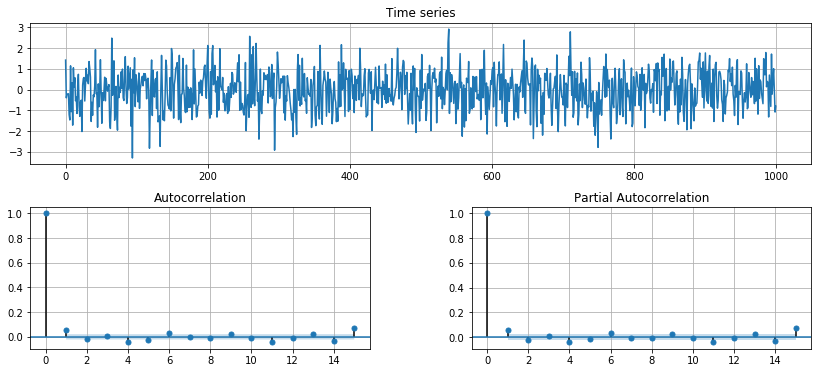

In [2]:
x = np.random.normal(size=1000)
tsplot(x)

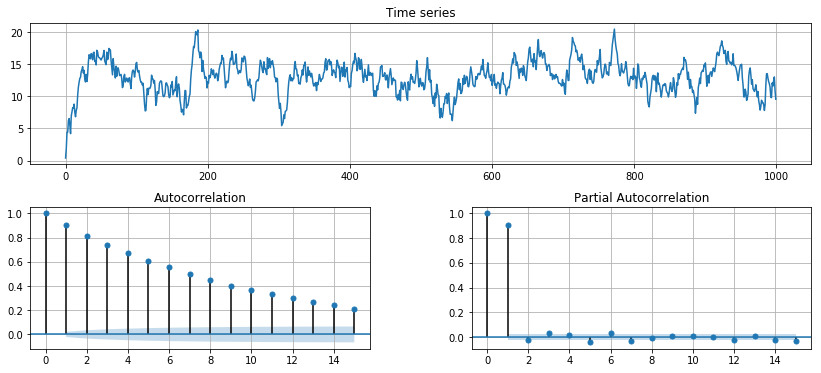

In [3]:
ndat = 1000
x = np.zeros(ndat)
x[0] = 0.4
for t in range(1, ndat):
    x[t] = 1.3 + .9*x[t-1] + np.random.normal()
tsplot(x)

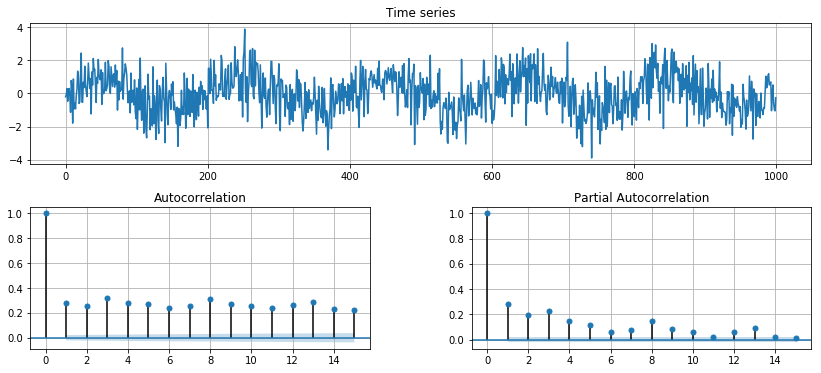

In [4]:
x = np.sin(np.linspace(0, 10*np.pi, 1000)) + np.random.normal(size=1000)
tsplot(x)

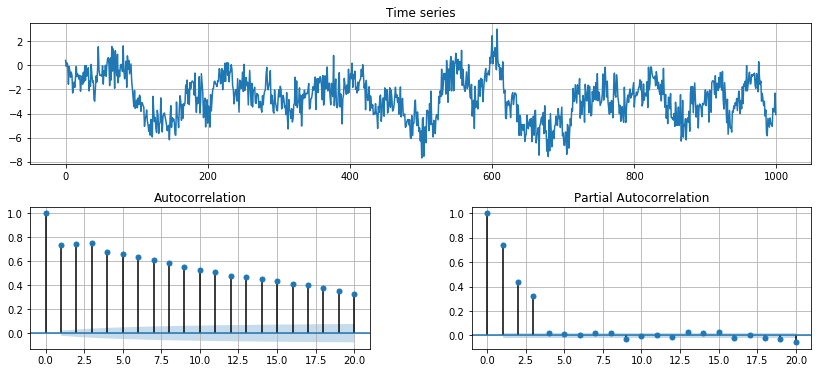

In [9]:
ndat = 1000
x = np.zeros(ndat)
x[0] = .4
x[1] = -.1
x[2] = .2
for t in range(3, ndat):
    x[t] = -.3 + .3*x[t-1] + .3*x[t-2] + .3*x[t-3] + np.random.normal()
tsplot(x, lags=20)

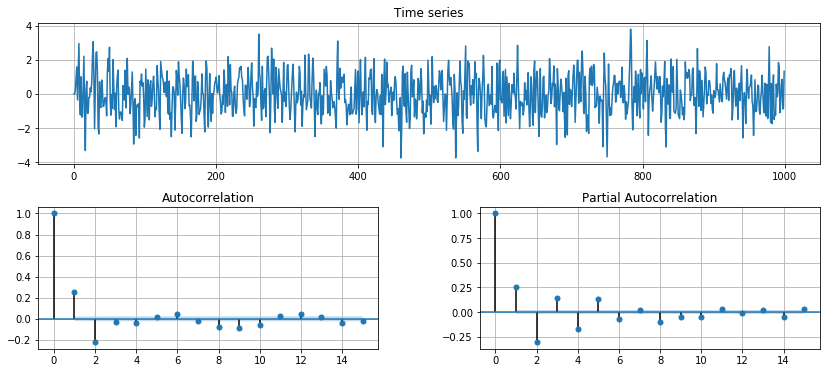

In [10]:
ndat = 1000
epsilon = np.random.normal(size=ndat)
x = np.zeros(ndat)
mean = 0
for t in range(2, ndat):
    x[t] = mean + epsilon[t] + .4*epsilon[t-1] - .3*epsilon[t-2]
tsplot(x)

## Autoregresní modely AR(p)

Autoregresní modely jsou jedny z nejpopulárnějších modelů v praxi, neboť umožňují popis náhodného procesu na základě jeho předchozích realizací.

> Definice
>
> Autoregresním modelem řádu $p$ nazýváme model
>
> $$
\begin{align}
X_t &= \beta_0 + \beta_1 X_{t-1} + \ldots + \beta_p X_{t-p} + \varepsilon_t \\
&= \beta_0 + \sum_{\tau=1}^p \beta_\tau X_{t-\tau} + \varepsilon_t \\
&=
\begin{bmatrix}
\beta_0 \\ \beta_1 \\ \vdots \\ \beta_{p}
\end{bmatrix}^\intercal
\begin{bmatrix}
1 \\ X_{t-1} \\ \vdots \\ X_{t-p}
\end{bmatrix}
+ \varepsilon_t
= \beta^{\intercal} \xi_t + \varepsilon_t = \xi_t^\intercal \beta + \varepsilon_t,
\end{align}
$$

> kde $\beta = [\beta_0, \ldots, \beta_p]^\intercal$ je vektor regresních koeficientů a $\varepsilon_t$ je bílý šum.

AR modely nemusí být slabě stacionární. Podmínkou, aby byly, je, že kořeny charakteristického polynomu 

$$
1 - \beta_1 z - \beta_2 z^2 - \ldots - \beta_p z^p  = 0
$$

ležely vně jednotkové kružnice, tj. pro každé (komplexní) $z_i\in\mathbb{C}$ platí $|z_i| > 1$. 

> **Příklad - AR(1)**: $X_t = \beta_0 + \beta_1 X_{t-1} + \varepsilon_t$
>
> - Kde $\varepsilon_t$ je bílý (ne nutně normální) šum s $\mathbb{E}[\varepsilon_t]=0$ a $\operatorname{var}\epsilon_t = \sigma^2$.
> - Proces je slabě stacionární při $|\beta_1|<1$, potom $\mathbb{E}[X_t] = \mu$ pro všechna $t$.
> - Střední hodnota a variance:
>$$
\begin{aligned}
\mathbb{E}[X_t] &= \mathbb{E}[\beta_0] + \beta_1\mathbb{E}[X_{t-1}] + \mathbb{E}[\varepsilon_t] 
\Rightarrow \mu = \frac{\beta_0}{1-\beta_1}, \\
\operatorname{var} X_t &= \mathbb{E}[X_t^2] - \mu = \frac{\sigma^2}{1-\beta_1^2}.
\end{aligned}
$$
>
>**Vyšetření stacionarity:** charakteristická rovnice má tvar
>
>$$
1 - \beta_1 z = 0,
$$
>
>tedy existuje kořen $z = 1/\beta_1$. Z podmínky pro stacionaritu $|z|>1$ plyne, že proces je stacionární pro $|\beta_1|<1$. Zkuste v simulacích výše :)

### Odhad řádu AR modelu

- ACF: postupně klesá k nule, popř. klesá shora i zdola
- PACF : vrcholy do hodnoty řádu modelu, pak jdou strmě k nule

Střední hodnota: 13.000
Variance: 5.263 (std: 2.294)


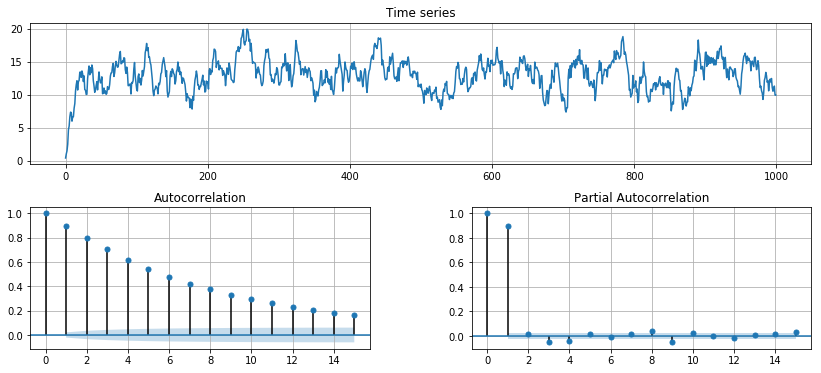

In [12]:
ndat = 1000
x = np.zeros(ndat)
x[0] = 0.4
sigma = 1
beta = [1.3, .9]
for i in range(1, ndat):
    x[i] = np.dot(beta, [1, x[i-1]]) + np.random.normal(scale=sigma)
tsplot(x)
print('Střední hodnota: {0:.3f}'.format(beta[0]/(1-beta[1])))
print('Variance: {0:.3f} (std: {1:.3f})'.format(sigma/(1-beta[1]**2), np.sqrt(sigma/(1-beta[1]**2))))

Zdá se, že byl identifikován AR(1). To znamená, že bychom čekali celkem lineární závislost $X_t$ a $X_{t-1}$, což můžeme ověřit obrázkem. Ale pozor, ACF je poměrně vysoká i pro další zpoždění, čili scatterplot nám vlastně tak úplně nepomáhá. Zkusme ostatně měnit `lag' níže...

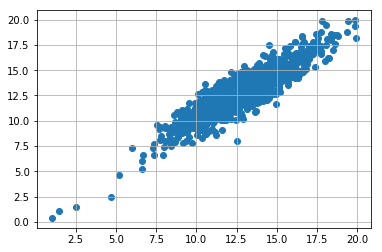

In [23]:
lag = 1
plt.scatter(x[lag:], x[:-lag])
plt.show()

### Příklad - AR(2)

Vezměme AR(2) model simulovaný s $\beta=[.1, -.5, .4]^\intercal$, odstartovaný z $X_1=.1, X_2=0$, s velmi malou variancí šumu $\varepsilon_t \sim \mathcal{N}(0, 0.01^2)$. Podívejme se na ACF a PACF:

![acfpacf](img/l3-ar2.png)

Scatterploty pro zpoždění 1-4 vypadají následovně: (proč?)

![scatter](img/l3-ar2-scatterplots.png)

Odhady na těchto 100 realizacích získané pomocí statsmodels byly $\hat{\beta}=[0.12780977, -0.589, 0.267]^\intercal$. Dat je málo a jsou málo vybuzená, proto jsou odhady horší. S rostoucím počtem dat by se zlepšovaly (proč?).

A konečně predikce na (nesmyslných ale demonstrativních) 100 kroků jsou následující (proč?):
![preds](img/l3-ar2-pred.png)

